In [1]:
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import copy
import json
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_preprocessed = np.load('/content/drive/MyDrive/academics/2ndyear/3/mini_project/img_csv/data_preprocessed.pkl', allow_pickle=True)

In [ ]:
res = []
for i in data_preprocessed:
  res.append(cv2.resize(i, dsize=(96, 96)))

In [ ]:
labels = np.load('/content/drive/MyDrive/academics/2ndyear/3/mini_project/img_csv/labels.pkl', allow_pickle=True)

In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(res, labels,test_size=0.20, stratify=labels, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 3

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(96, 96, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
type(trainY)

list

In [ ]:
H = model.fit(
	aug.flow(np.array(trainX), np.array(trainY).reshape((-1,1)), batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(np.array(testX), np.array(testY).reshape((-1,1))),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
1900/1900 [==============================] - 308s 159ms/step - loss: 0.1273 - accuracy: 0.6912 - val_loss: 0.2656 - val_accuracy: 0.6080
Epoch 2/20
1900/1900 [==============================] - 313s 165ms/step - loss: 0.0596 - accuracy: 0.7077 - val_loss: 0.0630 - val_accuracy: 0.6837
Epoch 3/20
1900/1900 [==============================] - 305s 161ms/step - loss: 0.0396 - accuracy: 0.7086 - val_loss: 0.2593 - val_accuracy: 0.6529
Epoch 4/20
1900/1900 [==============================] - 307s 161ms/step - loss: 0.0396 - accuracy: 0.7065 - val_loss: 0.8045 - val_accuracy: 0.5463
Epoch 5/20
1900/1900 [==============================] - 335s 176ms/step - loss: 0.0357 - accuracy: 0.7148 - val_loss: 0.1331 - val_accuracy: 0.6732
Epoch 6/20
1900/1900 [==============================] - 306s 161ms/step - loss: 0.0352 - accuracy: 0.7043 - val_loss: 0.0971 - val_accuracy: 0.7153
Epoch 7/20
1900/1900 [==============================] - 306s 161ms/step - loss: 0.0239 - accuracy: 0.7089 - val_

In [ ]:
predIdxs = model.predict(np.array(testX), batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
from sklearn.metrics import classification_report
# show a nicely formatted classification report
print(classification_report(np.array(testY), predIdxs))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.99      0.98       426

    accuracy                           0.99      1426
   macro avg       0.99      0.99      0.99      1426
weighted avg       0.99      0.99      0.99      1426



In [ ]:
model.save("model", save_format="h5")

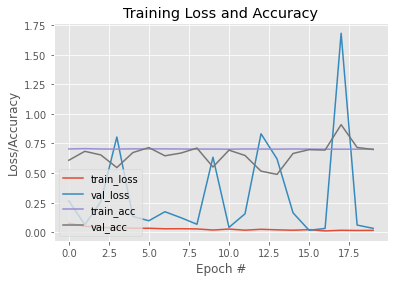

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")